In [1]:
from collections import Counter
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
from itertools import combinations, tee
from matplotlib.ticker import PercentFormatter
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re, csv, pickle, spacy, nltk, os, random, json, time, random, csv, os, datetime, lxml, glob, imutils, operator
import numpy as np
import pandas as pd
import researchpy as rp
import scipy.sparse as ss
import scipy.stats as stats
import seaborn as sns
from htmlparsing_kit import clean_sections
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pgeocode
%matplotlib inline

def create_xticks(dtf):
    qrtrs = []
    qlist = sorted(list(set(dtf['quarter'].tolist())))
    for i,qr in enumerate(qlist):
        qr = str(qr)
        qtr = qr.split('Q')[1]
        year = qr.split('Q')[0]
        if qtr == '1':
            newqr = '\n\n'.join([qtr,year])
        else:
            newqr = qtr
        qrtrs.append(newqr)
    return qrtrs, len(qlist)

def get_address(x):
    x = x.split(":",1)[-1].split(":",1)[-1].split(":",1)[-1].split(":",1)[-1].split(":",1)[-1].split(":",1)[-1].split(":",1)[0].strip()
    if x.endswith("Between"):
        address = x.split("Between",1)[0].strip()
    else:
        address = 'missing'
    return address

def write_json(jsonobj,filename):
    with open(filename,'a') as f:
        f.write(json.dumps(jsonobj)+'\n')
        
def get_addressloc(x,nomi,mainpath):
    if x != "missing":
        try:
            place = nomi.query_postal_code(x)
            pdf = pd.DataFrame(place).T
            pdf['query'] = x
            pdf.to_csv(mainpath + "output/7_addresses.csv",sep='\t',index = False,mode='a')
            locale = place['place_name']
        except:
            locale = "error"
    else:
        locale = "missing"
    return locale

def get_winloss(df20,tname):
    qframes = []
    for n,g in df20.groupby(['monthyear']):
        g = g[g['tname']==tname]
        winlossdict = {}
        winlossdict['Month-Year'] = str(n)
        winlossdict['Landlord Wins'] = 0.0
        winlossdict['Landlord Losses'] =0.0
        winlossdict['Tenant Wins'] = 0.0
        winlossdict['Tenant Losses'] =0.0
        winlossdict['Landlord Applications'] =0.0
        winlossdict['Tenant Applications'] =0.0
        qcasecount = sum(g['numone'].tolist())
        winlossdict['Order Count'] = qcasecount
        for l1,h1 in g.groupby(['applicant']):
            if l1=='l':
                winlossdict['Landlord Applications']=sum(h1['numone'].tolist())
            else:
                winlossdict['Tenant Applications']=sum(h1['numone'].tolist())
        for l,h in g.groupby(['applicant','winner']):
            if l[0] == 'l' and l[1] == 'l':
                winlossdict['Landlord Wins'] = round(sum(h['numone'].tolist())/qcasecount,3)
            elif l[0] == 'l' and l[1] == 't':
                winlossdict['Landlord Losses'] = round(sum(h['numone'].tolist())/qcasecount,3)
            elif l[0] == 't' and l[1] == 't':
                winlossdict['Tenant Wins'] = round(sum(h['numone'].tolist())/qcasecount,3)
            else:
                winlossdict['Tenant Losses'] = round(sum(h['numone'].tolist())/qcasecount,3)
                continue
        wldf = pd.DataFrame(list(winlossdict.values())).T.reset_index()
        del wldf['index']
        wldf.columns = ['Month-Year','Landlord Wins','Landlord Losses','Tenant Wins','Tenant Losses','Landlord Applications','Tenant Applications','Order Count']
        qframes.append(wldf)
    ydf = pd.concat(qframes)
    ydf['tname'] = tname
    return ydf

def get_winlossfull(df):
    qframes = []
    for n,g in df.groupby(['quarter']):
        winlossdict = {}
        winlossdict['quarter'] = str(n)
        winlossdict['Landlord Wins'] = 0.0
        winlossdict['Landlord Losses'] =0.0
        winlossdict['Tenant Wins'] = 0.0
        winlossdict['Tenant Losses'] =0.0
        winlossdict['llcasecount'] =0.0
        winlossdict['ttcasecount'] =0.0
        winlossdict['qcasecount'] = sum(g['numone'].tolist())
        for l1,h1 in g.groupby(['applicant']):
            if l1=='l':
                winlossdict['llcasecount']= sum(h1['numone'].tolist())
            else:
                winlossdict['ttcasecount']=sum(h1['numone'].tolist())
        for l,h in g.groupby(['applicant','winner']):
            if l[0] == 'l' and l[1] == 'l':
                winlossdict['Landlord Wins'] = round(sum(h['numone'].tolist())/winlossdict['qcasecount'],3)
            elif l[0] == 'l' and l[1] == 't':
                winlossdict['Landlord Losses'] = round(sum(h['numone'].tolist())/winlossdict['qcasecount'],3)
            elif l[0] == 't' and l[1] == 't':
                winlossdict['Tenant Wins'] = round(sum(h['numone'].tolist())/winlossdict['qcasecount'],3)
            else:
                winlossdict['Tenant Losses'] = round(sum(h['numone'].tolist())/winlossdict['qcasecount'],3)
                continue
        wldf = pd.DataFrame(list(winlossdict.values())).T.reset_index()
        del wldf['index']
        wldf.columns = ['quarter','llwins','llloss','ttwins','ttloss','llcasecount','ttcasecount','casecount']
        qframes.append(wldf)
    ydf = pd.concat(qframes)
    return ydf

def plottopic(ydfn,tname,topiccolors,colordict):
    xaxislabels = []
    for m in sorted(list(set(ydfn['Month-Year'].tolist()))):
        if str(m).split('-')[1] == '06':
            xl = '\n\n'.join([str(m).split('-')[1],str(m).split('-')[0]])
        else:
            xl = str(m).split('-')[1]
        xaxislabels.append(xl)
    fig, ax = plt.subplots()
    
    plt.axvspan(2.65, 6.35, color=colordict['blackwhite'][2], alpha=0.3, lw=5)
    plt.axvspan(11.65, 22.35, color=colordict['blackwhite'][2], alpha=0.3, lw=5)
    ydfn.plot(ax=ax, x='Month-Year', y=['Landlord Applications','Tenant Applications'], secondary_y=True, label=['Landlord Applications','Tenant Applications'], linewidth=4,xlabel=None, ylabel=None,grid=True,color=[colordict['blue'][3],colordict['pink'][0]],legend=False)
    ydfn[['Month-Year','Landlord Wins','Landlord Losses','Tenant Wins','Tenant Losses']].plot(kind='bar', stacked=True,figsize=(17, 5),color=[colordict['blue'][1],colordict['blue'][4],colordict['pink'][2],colordict['pink'][4]],ax=ax,width=0.7)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.size"] = 16
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    y_min, y_max = ax.get_ylim()
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.tick_params(axis='x', which='major', pad=10)
    plt.title('"'+tname+'"'+" ("+str(ydfn['Order Count'].sum()).split('.',1)[0]+" Cases)", pad=10)
    ax.get_legend().remove()
    plt.yticks(rotation =0,fontsize=16,fontname='serif')
    plt.xticks(rotation =90,fontsize=16,fontname='serif')
    plt.savefig(mainpath + 'graphs/topics/svmmodel_dist_'+tname+'.png', dpi=600, bbox_inches='tight')
    plt.savefig(mainpath + 'graphs/topics/svgs/svmmodel_dist_'+tname+'.svg', dpi=600, bbox_inches='tight')



colordict = {"blue":['#0b00ff','#0063ff','#0092ff','#2ab9ff','#a7daf6'],
"red":["#ff0000","#ff4f41","#ff7970","#ff9f9b","#f5c2c2"],
"pink":["#ff00fe","#f556f7","#eb79ef","#e194e5","#d7abda"],
"green":["#093f05","#265a21","#40763c","#5b9458","#76b276"],
"yellow":["#ffe700","#e3d42f","#c9c141","#b1ad4e","#9b9a57"],
"orange":[ "#ff7101","#f37927","#e7813e","#da8752","#cc8d65","#FFD9B3"],
"purple":["#6001ff","#7536ff","#8753ff","#986cff","#a884fd"],
"blackwhite":["#020003","#48454c","#908d9b","#dedef3"]}

colorlist = []
for l in list(colordict.values()):
    colorlist.extend(l)

newtopicnames = {
    11:"Rent Changes", 
    10:"Moratorium", 
    12:"Nonpayment",
    13:"Failed Condition",
    9:"Nonpayment",
    5:"Moratorium",
    7:"Nonpayment",
    6:"Nonpayment",
    4:"Nonpayment",
    8:"Agree Terminate",
    14:"Nonpayment",
    2:"Nonpayment",
    0:"Failed Condition",
    3:"Breaking Rules",
    1:"Nonpayment"
}

nomi = pgeocode.Nominatim('ca')

mainpath = str(os.getcwd())+'/'

print('------------------------------------------')
df20 = pd.read_csv(mainpath+"output/6_case_db_202021.csv",sep='\t')
df20['datetime'] = pd.to_datetime(df20['date'])
df20['year'] = df20['datetime'].dt.year
df20['monthyear'] = pd.PeriodIndex(df20.datetime, freq='M')
df20['quarter'] = pd.PeriodIndex(df20.datetime, freq='Q')
df20['numone'] = 1
df20['tname'] = df20['topic'].map(newtopicnames)
df20.fillna(np.nan,inplace=True)
print(df20.shape)
print(df20['applicant'].value_counts())
print(df20['winner'].value_counts())
print(pd.crosstab(df20.winner, df20.applicant))
print('------------------------------------------')

df = pd.read_csv(mainpath+"output/5_model_results.csv",sep='\t')
df['cleansections']=df['sections'].apply(lambda x: clean_sections(x))
df['datetime'] = pd.to_datetime(df['date'])
df['year'] =df['datetime'].dt.year
df['quarter'] = pd.PeriodIndex(df.datetime, freq='Q')
df['monthyear'] = pd.PeriodIndex(df.datetime, freq='M')
df['numone'] = 1
print(df.shape)
df = df[df['year']!=2006]
df.fillna(np.nan,inplace=True)
print(df.shape)
print(df['applicant'].value_counts())
print(df['winner'].value_counts())
print(pd.crosstab(df.winner, df.applicant))
print('------------------------------------------')

traindf = pd.read_csv(mainpath+'output/4_traindataplus.csv',sep='\t')
traindf = traindf[traindf['outcome']!='nottrainingsample']
print(traindf.shape)
print(traindf['applicant'].value_counts())
print(traindf['winner'].value_counts())
print(pd.crosstab(traindf.winner, traindf.applicant))
print('------------------------------------------')

2022-02-07 12:01:59.167070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-07 12:01:59.167095: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


------------------------------------------
(17744, 37)
l    17271
t      473
Name: applicant, dtype: int64
l    15380
t     2364
Name: winner, dtype: int64
applicant      l    t
winner               
l          15255  125
t           2016  348
------------------------------------------
(36461, 35)
(36460, 35)
l    30427
t     6033
Name: applicant, dtype: int64
l    26136
t    10324
Name: winner, dtype: int64
applicant      l     t
winner                
l          24061  2075
t           6366  3958
------------------------------------------
(1636, 29)
l    1133
t     503
Name: applicant, dtype: int64
l    968
t    668
Name: winner, dtype: int64
applicant    l    t
winner             
l          798  170
t          335  333
------------------------------------------


<h2> SJTO Applications by Resolution Type VS Custom DB </h2>

In [2]:
yearcount = df['year'].value_counts().reset_index()
yearcount.columns = ['year','count']
# yearcount = yearcount[(yearcount['year']>=2010)&(yearcount['year']<=2020)]
ycdict = dict(zip(yearcount['year'],yearcount['count']))

sjdf = pd.read_csv(mainpath +'output/sjto_data/appresolutionstats_sjto.csv',sep='\t')
del sjdf['notes']
sjdf = sjdf[sjdf['Resolution Type']== 'Total']
del sjdf['Resolution Type']

sjdf.columns = [int(x) for x in ['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010']]
sjdf = sjdf.T.reset_index()
sjdf.columns = ['year','sjtocount_resolution']
sjdf['dcount'] = sjdf['year'].map(ycdict)
sjdf['sjtocount_resolution'] = sjdf['sjtocount_resolution'].astype(int)
# sjdf.set_index('year')
sjdf

,year,sjtocount_resolution,dcount
0,2020,35983,4499
1,2019,72064,890
2,2018,79476,1996
3,2017,78260,2462
4,2016,78783,2059
5,2015,77773,1411
6,2014,77148,469
7,2013,82126,1409
8,2012,80261,2554
9,2011,81032,2141


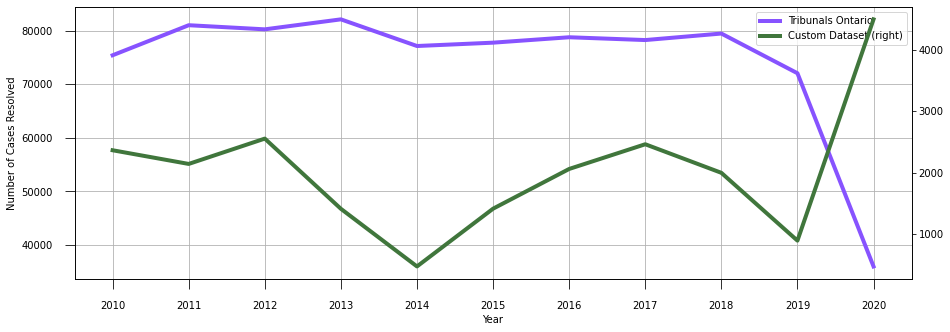

In [3]:
fig, axs = plt.subplots(figsize=(15,5))
axs.tick_params(axis='both', which='major', pad=12,length=10)

sjdf.plot(ax=axs, x='year', y='sjtocount_resolution', grid=True, label="Tribunals Ontario", linewidth=4,xlabel='Year',ylabel = "Number of Cases Resolved",color=colordict['purple'][2])
sjdf.plot(ax=axs, x='year', y='dcount', secondary_y=True, label="Custom Dataset", linewidth=4,xlabel='Year', grid=True,xticks = sorted(sjdf['year'].tolist()),color=colordict['green'][2])
plt.rcParams['legend.loc'] = "best"
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 16
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['axes.titlesize'] = 16
# plt.savefig(mainpath + 'graphs/sjtovscustomdb.png', dpi=600, bbox_inches='tight')
plt.show()

<h2> Cases by Office Location </h2>

In [4]:
alllocs = sorted(list(set(df['newloc'].tolist())))
newlocframes = []
for n,g in df.groupby(['year']):
    g2 = g['newloc'].value_counts().reset_index().T
    g2.columns = g2.iloc[0]
    g2 = g2.iloc[1:]
    g2cols = list(g2.columns)
    missingcols = list(set(alllocs)-set(g2cols))
    for m in missingcols:
        g2[m] = 0
    g2['year'] = n
    newlocframes.append(g2)
nlocdf = pd.concat(newlocframes)
nlocdf = nlocdf[['year','Southern_Hamilton', 'SouthWest_London','Central_Mississauga', 'Eastern_Ottawa', 'Northern_Sudbury', 'TOEast', 'HeadOffice_Toronto', 'TONorth', 'TOSouth','missing']]

<h2> Custom Applicant Win/loss Rates </h2>

In [5]:
ydf = get_winlossfull(df)
print(ydf.shape)

(60, 8)


In [6]:
df.shape

(36460, 35)

<h2> Custom Cumulative Distribution of Applicants by Ruling </h2>

In [7]:
qrtrs = ['2007', '', '', '', '2008', '', '', '','2009', '', '', '', '2010', '', '', '', '2011', '', '', '', '2012', '', '', '', '2013', '', '', '', '2014', '', '', '', '2015', '', '', '','2016', '', '', '', '2017', '', '', '', '2018', '', '', '', '2019', '', '', '', '2020', '', '', '', '2021', '', '', '']
qrtrslen = len(qrtrs)

In [8]:
print(sum(ydf['llcasecount'].tolist())+sum(ydf['ttcasecount'].tolist()))
print(sum(ydf['casecount'].tolist()))

36460
36460


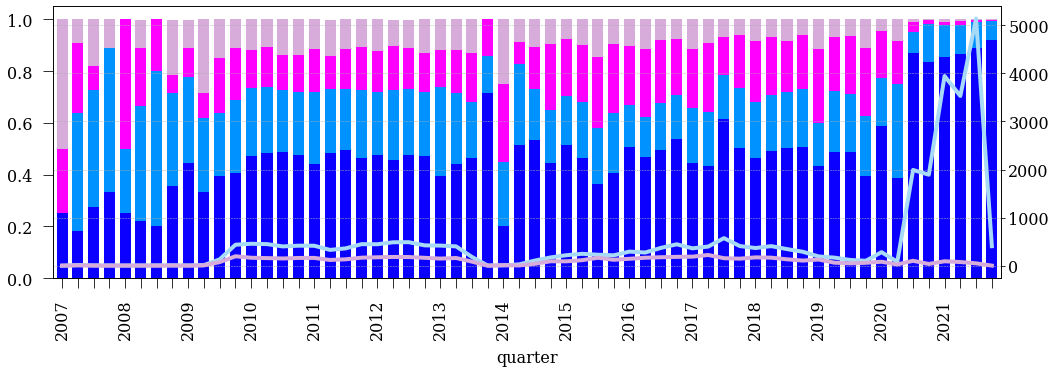

In [9]:
fig, ax = plt.subplots()
ydf.plot(ax=ax, x='quarter', y=['llcasecount','ttcasecount'], secondary_y=True, label=['Landlord Applications','Tenant Applications'], linewidth=4,xlabel=None, ylabel=None,grid=True,color=[colordict['blue'][4],colordict['pink'][4]],legend=False)
ydf[['quarter','llwins','llloss','ttwins','ttloss']].plot(kind='bar', stacked=True,figsize=(17, 5),color=[colordict['blue'][0],colordict['blue'][2],colordict['pink'][0],colordict['pink'][4]],ax=ax,width=0.7,xlabel=None, ylabel=None)

ax.set_xticks(np.arange(0,qrtrslen,1))
ax.set_xticklabels(qrtrs)
ax.tick_params(length=10, which='both', pad=10)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 16
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

plt.xticks(rotation =0,fontsize=16,fontname='serif')
plt.yticks(rotation =0,fontsize=16,fontname='serif')
plt.xlabel('Quarter', fontsize=18,labelpad=10,fontname='serif')
plt.grid(linestyle = '--', linewidth = 0.5)
ax.get_legend().remove()
plt.savefig(mainpath + 'graphs/svmmodel_dist.png', dpi=600, bbox_inches='tight')
plt.savefig(mainpath + 'graphs/svgs/svmmodel_dist.svg', dpi=600, bbox_inches='tight')

<h2> Custom Proportion of Applications Won by Landlords and Tenants Across Topics </h2>

In [35]:
df20['tname'].value_counts()

Nonpayment          11129
Failed Condition     2555
Breaking Rules       2545
Agree Terminate      1016
Moratorium            379
Rent Changes          120
Name: tname, dtype: int64

In [36]:
nonpayment = get_winloss(df20,"Nonpayment")
rules = get_winloss(df20,"Breaking Rules")
failcond = get_winloss(df20,"Failed Condition")
agreetermin = get_winloss(df20,"Agree Terminate")
rent = get_winloss(df20,"Rent Changes")
moratorium = get_winloss(df20,"Moratorium")

In [1]:
plottopic(nonpayment,"Nonpayment",topicolors,colordict)

In [2]:
plottopic(rules,"Breaking Rules",topicolors,colordict)

In [3]:
plottopic(failcond,"Failed Condition",topicolors,colordict)

In [4]:
plottopic(rent,"Rent Changes",topicolors,colordict)

In [5]:
plottopic(moratorium,"Moratorium",topicolors,colordict)

In [6]:
plottopic(agreetermin,"Agree Terminate",topicolors,colordict)